In [1]:
import os
import random
import numpy as np

from tqdm import tqdm 

from skimage.transform import resize
from skimage.io import imread, imshow

import matplotlib.pyplot as plt
%matplotlib inline




In [2]:
import tensorflow as tf

In [3]:
!pip show tensorflow

Name: tensorflow
Version: 2.10.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: c:\users\vj\anaconda3\envs\gpu\lib\site-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, keras-preprocessing, libclang, numpy, opt-einsum, packaging, protobuf, setuptools, six, tensorboard, tensorflow-estimator, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: 


In [4]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
# Use the GPU more efficiently.
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [6]:
seed = 42
np.random.seed = seed

IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

TRAIN_PATH = 'data-science-bowl-2018/stage1_train/'
TEST_PATH = 'data-science-bowl-2018/stage1_test/'


Resizing training images and masks


100%|██████████| 670/670 [04:38<00:00,  2.41it/s]


Resizing test images


100%|██████████| 65/65 [00:01<00:00, 47.48it/s]


Done!


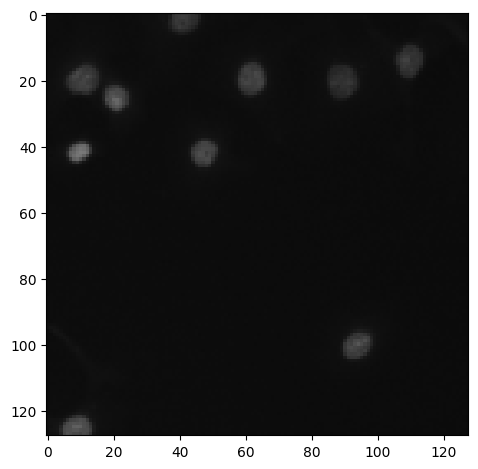

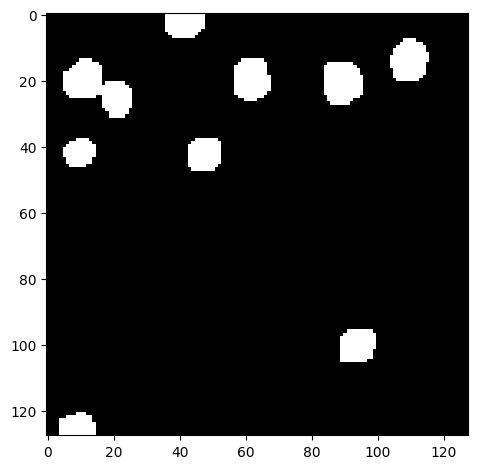

In [7]:

train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)

print('Resizing training images and masks')
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):   
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]  
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img  #Fill empty X_train with values from img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant',  
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)  
            
    Y_train[n] = mask   

# test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Resizing test images') 
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

image_x = random.randint(0, len(train_ids))
imshow(X_train[image_x])
plt.show()
imshow(np.squeeze(Y_train[image_x]))
plt.show()


In [8]:
#Build the model
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 128, 128, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  448         ['lambda[0][0]']                 
                                )                                                                 
                                                                                              

In [9]:
#Modelcheckpoint
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_nuclei.h5', verbose=1, save_best_only=True)

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=4, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')]

results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=100, callbacks=callbacks)



Epoch 1/100
38/38 [==============================] - 16s 158ms/step - loss: 0.5314 - accuracy: 0.7460 - val_loss: 0.2879 - val_accuracy: 0.8365
Epoch 2/100
38/38 [==============================] - 3s 71ms/step - loss: 0.2445 - accuracy: 0.8991 - val_loss: 0.1642 - val_accuracy: 0.9322
Epoch 3/100
38/38 [==============================] - 3s 72ms/step - loss: 0.1702 - accuracy: 0.9343 - val_loss: 0.1463 - val_accuracy: 0.9403
Epoch 4/100
38/38 [==============================] - 3s 72ms/step - loss: 0.1449 - accuracy: 0.9447 - val_loss: 0.1322 - val_accuracy: 0.9488
Epoch 5/100
38/38 [==============================] - 3s 74ms/step - loss: 0.1309 - accuracy: 0.9501 - val_loss: 0.1108 - val_accuracy: 0.9558
Epoch 6/100
38/38 [==============================] - 3s 72ms/step - loss: 0.1294 - accuracy: 0.9508 - val_loss: 0.1028 - val_accuracy: 0.9599
Epoch 7/100
38/38 [==============================] - 3s 71ms/step - loss: 0.1201 - accuracy: 0.9553 - val_loss: 0.1057 - val_accuracy: 0.9592
Epoc

Run the following command in cmd to visualize the training process.

tensorboard --logdir=logs/ --host localhost --port 8080

Then open the browser and go to http://localhost:8080/ to see the training process.


In [10]:
model.save("U-net-model.h5")

3/3 [==============================] - 1s 299ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   9879552

    accuracy                           1.00   9879552
   macro avg       1.00      1.00      1.00   9879552
weighted avg       1.00      1.00      1.00   9879552



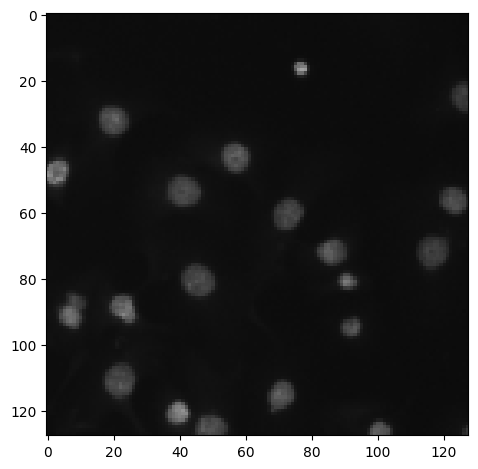

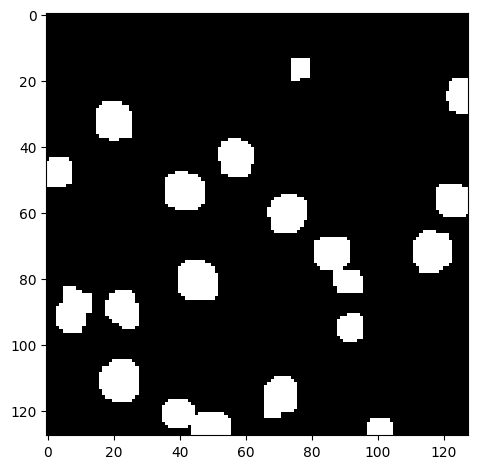

c:\Users\VJ\anaconda3\envs\gpu\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:158: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


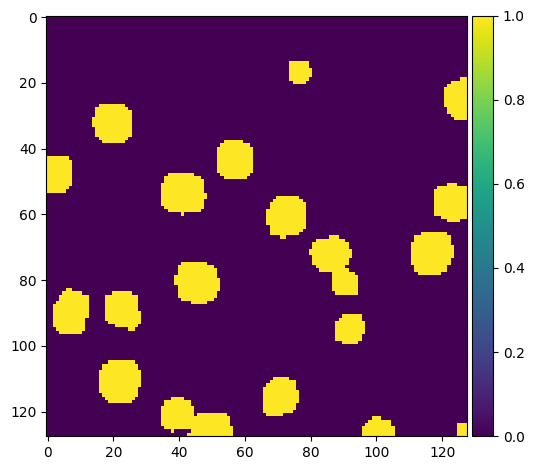

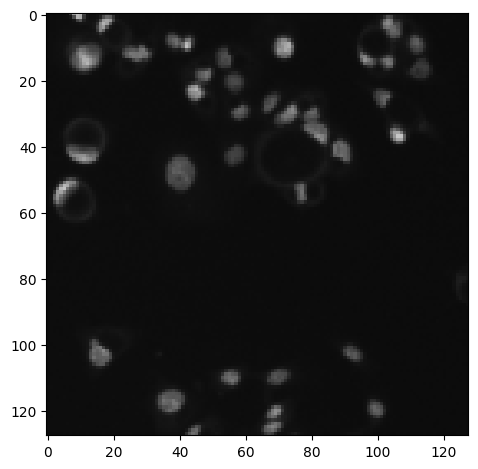

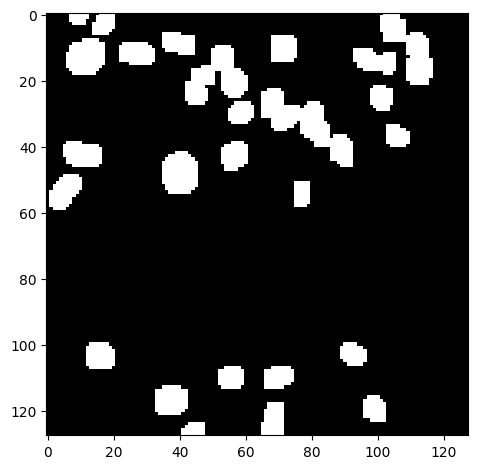

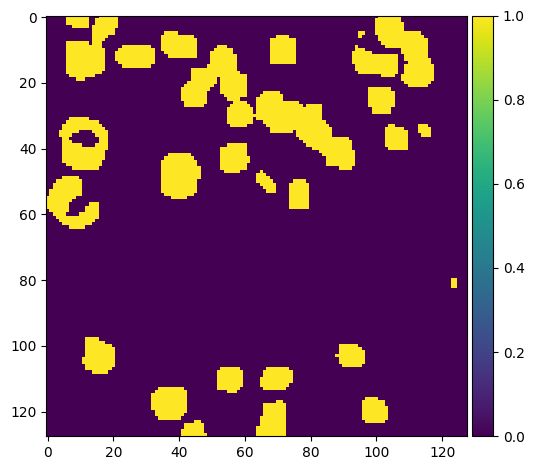

In [11]:
idx = random.randint(0, len(X_train))


preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

 
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

from sklearn.metrics import classification_report

# Flatten your predictions and true labels
preds_train_flat = np.argmax(preds_train_t.reshape(-1, preds_train_t.shape[-1]), axis=1)
Y_train_flat = np.argmax(Y_train[:int(Y_train.shape[0]*0.9)].reshape(-1, Y_train.shape[-1]), axis=1)

# Generate classification report
report = classification_report(Y_train_flat, preds_train_flat)

# Print classification report
print(report)


# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

In [12]:
import pickle

model_name = "U-net_segementation.h5"
pickle.dump(model, open(model_name, 'wb'))

INFO:tensorflow:Assets written to: ram://c56133fd-b780-4f36-bbe7-b611de14dd22/assets


INFO:tensorflow:Assets written to: ram://c56133fd-b780-4f36-bbe7-b611de14dd22/assets


In [13]:
import keras
loaded_model = keras.models.load_model('U-net-model.h5')

1/1 [==============================] - 0s 247ms/step


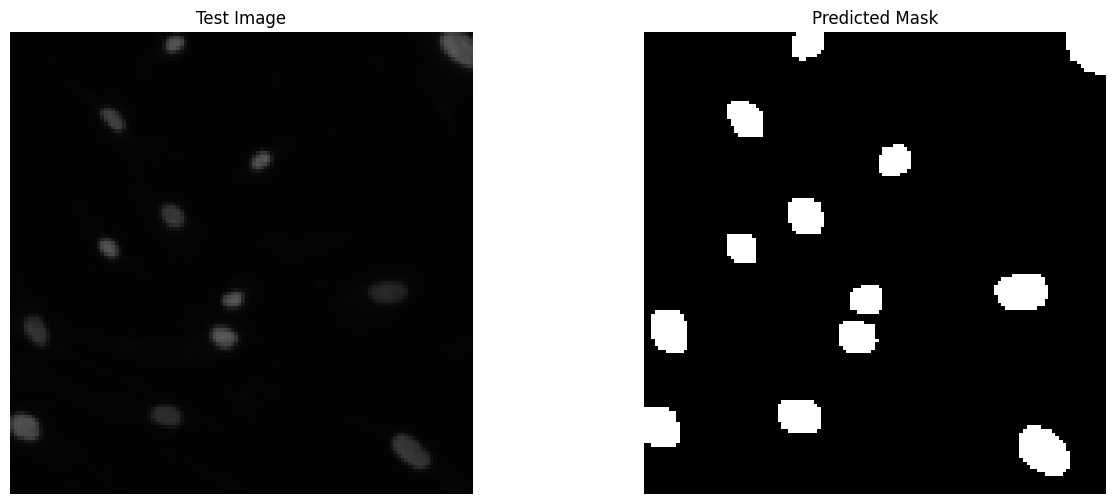

In [14]:
import numpy as np
import os
from skimage.io import imread
from skimage.transform import resize
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import random

# Define constants
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

# Path to the saved model
model_path = "U-net-model.h5"

# Path to the test image
TEST_IMAGE_PATH = 'data-science-bowl-2018/stage1_test/'

# Function to preprocess test images
def preprocess_test_image(image_path):
    img = imread(image_path)[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    return img

# Load the saved model
model = load_model(model_path)

# Check if the test image directory exists
if os.path.exists(TEST_IMAGE_PATH):
    # Choose a random test image
    test_image_id = random.choice(os.listdir(TEST_IMAGE_PATH ))
    test_image = preprocess_test_image(TEST_IMAGE_PATH + test_image_id+ '/images/'+ test_image_id + '.png')

    # Expand the dimensions of the test image to create a batch of size 1
    test_image_batch = np.expand_dims(test_image, axis=0)

    # Predict segmentation mask
    pred_mask = model.predict(test_image_batch)

    # Threshold the predicted mask
    pred_mask_thresholded = (pred_mask > 0.5).astype(np.uint8)

    # Plot the test image and predicted mask
    plt.figure(figsize=(15, 6))

    # Test image
    plt.subplot(1, 2, 1)
    plt.imshow(test_image.astype(np.uint8))
    plt.title('Test Image')
    plt.axis('off')

    # Predicted mask
    plt.subplot(1, 2, 2)
    plt.imshow(np.squeeze(pred_mask_thresholded), cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')

    plt.show()
else:
    print("Test image directory does not exist or is empty.")
